In [1]:
from galpy.potential import NFWPotential, MiyamotoNagaiPotential,HernquistPotential,plotRotcurve
import astropy.units as u
from galpy.util import conversion, save_pickles, coords, plot
import numpy as np
from galpy import potential
print (conversion._G) #pc / Msolar (km/s)^2
from galpy.orbit import Orbit
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
from scipy import integrate, interpolate, signal
import pickle
import glob
import csv

0.00430091727003628


In this notebook, we will :

1. Setup the the streamdf object for the mock GD-1 stream
2. Setup transformation matrix to go from (ra,dec) to custom GD-1 coordinates
3. Use results from the subhalo impact simulations to plot the power spectrum

We have obtained $r$ and $\frac{M(<r)}{r^2}$ of the live MW halo (with resolution $10^5$ M$_{\odot}$) 

In [2]:
#Mres = 1e5 Msun
rgrid = np.array([1.0, 1.620253164556962, 2.240506329113924, 2.8607594936708862, 3.481012658227848,
         4.10126582278481, 4.7215189873417724, 5.341772151898734, 5.962025316455696,
         6.582278481012658, 7.20253164556962, 7.822784810126582, 8.443037974683545, 
         9.063291139240507, 9.683544303797468, 10.30379746835443, 10.924050632911392,
         11.544303797468354, 12.164556962025316, 12.784810126582277, 13.40506329113924,
         14.025316455696203, 14.645569620253164, 15.265822784810126, 15.886075949367088, 
         16.50632911392405, 17.126582278481013, 17.746835443037973, 18.367088607594937,
         18.987341772151897, 19.60759493670886, 20.22784810126582, 20.848101265822784,
         21.468354430379748, 22.088607594936708, 22.70886075949367, 23.32911392405063, 
         23.949367088607595, 24.569620253164555, 25.189873417721518, 25.81012658227848,
         26.430379746835442, 27.050632911392405, 27.670886075949365, 28.29113924050633,
         28.91139240506329, 29.531645569620252, 30.151898734177212, 30.772151898734176, 
         31.39240506329114, 32.0126582278481, 32.63291139240506, 33.25316455696203,
         33.87341772151898, 34.49367088607595, 35.11392405063291, 35.734177215189874,
         36.35443037974684, 36.974683544303794, 37.59493670886076, 38.21518987341772,
         38.835443037974684, 39.45569620253164, 40.075949367088604, 40.69620253164557,
         41.31645569620253, 41.936708860759495, 42.55696202531645, 43.177215189873415, 
         43.79746835443038, 44.41772151898734, 45.0379746835443, 45.65822784810126, 
         46.278481012658226, 46.89873417721519, 47.51898734177215, 48.13924050632911,
         48.75949367088607, 49.379746835443036, 50.0]) #in kpc

m_over_r2 = np.array([0.10738246142864227, 0.09845212732943764, 0.09336166768108434,
                      0.08909043318906584, 0.08541126902241353, 0.0821231540472492, 
                      0.07906372802021001, 0.07638001879341012, 0.07379467293207213,
                      0.07132184725453164, 0.0690528020866983, 0.06690969331050176,
                      0.0648670107637155, 0.0629247910403598, 0.06115523695726764,
                      0.05941708983712577, 0.057754700664653345, 0.05617594001966648,
                      0.05469924672857998, 0.05324612854579047, 0.051866263211996895,
                      0.050556075702075064, 0.04927898718290904, 0.04807714547558049,
                      0.04689822182988586, 0.04576537206434164, 0.044686880469953415,
                      0.043647862101065714, 0.0426583893189878, 0.041690096172332776,
                      0.04076868635081027, 0.039880074197205274, 0.0390214284048719,
                      0.03817897557750763, 0.03737766864972137, 0.03659427413601633,
                      0.03584532037860031, 0.03511260267079368, 0.03440948259375023,
                      0.03372475691490205, 0.0330657116452067, 0.03242999011161868, 
                      0.03180966477294754, 0.031213024451557377, 0.030633822361588837,
                      0.030068904748923927, 0.029520835943614137, 0.028986059103884285,
                      0.028471141214763417, 0.02796936206496345, 0.027480119457985147,
                      0.027003188825860284, 0.026538136719286596, 0.02608808711070303,
                      0.02565083608146509, 0.025225487238234128, 0.024809394517110173,
                      0.024402980472162064, 0.02401216077282636, 0.023629880776559024,
                      0.02325861072268433, 0.0228965611632571, 0.022542897807058954,
                      0.022195563146832187, 0.02185608348120908, 0.021526711218428585,
                      0.021205520148143853, 0.020895149702207842, 0.02058711389797605,
                      0.020287175412254357, 0.01999679784611772, 0.01971166196613089,
                      0.019433253292072836, 0.019161382756810105, 0.0188959346847113,
                      0.01863715186982597, 0.018381947205696338, 0.018134122517156973,
                      0.017891681778732335, 0.017654316711425783]) #10^10Msun/kpc^2

Interpolate them to create a function, also change all units to galpy units \
Add MWPotential2014's disk potential

In [3]:
ro = 8.
vo= 220.

interp_m_over_r2 = UnivariateSpline(rgrid,m_over_r2) #10^10Msun/kpc^2

def rad_acc(r): #input r is in galpy units
    r*=ro #r is now in physical units
    acc = 1e10*interp_m_over_r2(r)*(conversion._G*0.001) #(km/s)^2/kpc
    acc*=(0.001*conversion._kmsInPcMyr) #km/s/Myr
    acc*=(-1./conversion.force_in_kmsMyr(vo,ro))#in galpy units
    return (acc)

Phi0 = rad_acc(rgrid[0]/ro)*(rgrid[0]/ro) # in galpy units


ip_halo= potential.interpSphericalPotential(rforce=rad_acc,rgrid=rgrid/ro,Phi0=Phi0)
ip_halo.turn_physical_off() #just to be sure


disk_pot = MiyamotoNagaiPotential(amp=5.78*10**10*u.Msun,a=3.5*u.kpc,b=0.5*u.kpc)
disk_pot.turn_physical_off()

tot_pot = ip_halo + disk_pot

Plot circular velocity and check

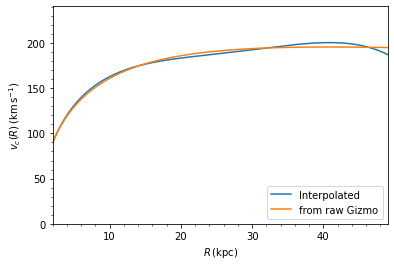

In [4]:
plotRotcurve(ip_halo,ro=8.,vo=220.,label="Interpolated",Rrange=[2.,49.])
plt.plot(rgrid,np.sqrt(m_over_r2*rgrid*(conversion._G*0.001)*1e10),label="from raw Gizmo")
plt.legend(loc="lower right")

There is an offset near R=50 kpc probably because of edge effects but that's should be ok in this analysis
since the stream never goes that far. 

With the above interpolated potential, we will now evaluate the isochrone parameter 

In [5]:
from galpy.actionAngle import estimateBIsochrone, actionAngleIsochroneApprox

o1= Orbit.from_name("GD1")
orb_galpy=o1.vxvv

ts1=np.linspace(0.,-4.,1000)/conversion.time_in_Gyr(vo,ro)
o1.integrate(ts1,tot_pot)

print (estimateBIsochrone(tot_pot,o1.R(ts1)/ro,o1.z(ts1)/ro))

[0.73810081 0.91587409 1.0688301 ]


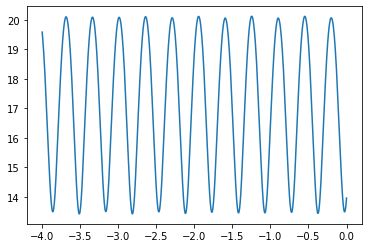

mean spherical radius =  17.010436107273957


In [6]:
plt.figure()
plt.plot(ts1*conversion.time_in_Gyr(vo,ro),o1.r(ts1))
plt.show()

print ("mean spherical radius = ",np.mean(o1.r(ts1)))

This matches with the live N-body orbit as well as the orbit in the Gizmo interpolated halo 

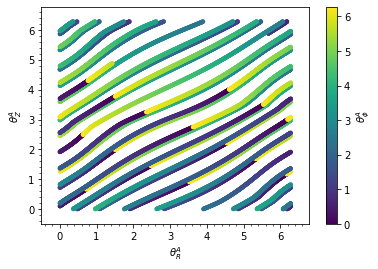

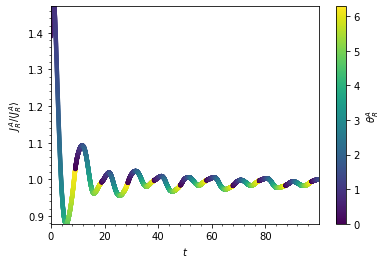

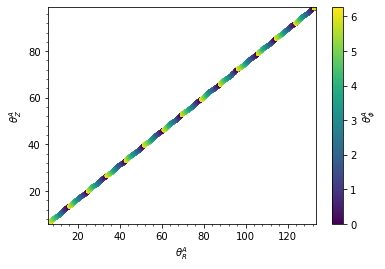

In [7]:
#Trial and error seems to indicate b = 0.5 works well, 
#although this is out of range based on the isochrone estimate above

aAIA= actionAngleIsochroneApprox(pot=tot_pot,b=0.5)
aAIA(*orb_galpy[0])

aAIA.plot(*orb_galpy[0],type='araz')

aAIA.plot(*orb_galpy[0],type='jr')

aAIA.plot(*orb_galpy[0],type='araz',deperiod=True)

Next, let's setup the smooth stream. Using $\sigma_{v} = 0.46$ km/s, obtained by computing the velocity dispersion
of the progenitor King cluster.

In [8]:
from galpy.df import streamdf, streamgapdf
from streampepperdf_new import streampepperdf
from galpy.orbit import Orbit
from galpy.potential import LogarithmicHaloPotential
from galpy.potential import MWPotential2014
from galpy.actionAngle import actionAngleIsochroneApprox
from galpy.util import conversion #for unit conversions


R0, V0= 8., 220.
def setup_mockgd1model(leading=True,pot=MWPotential2014,
                   timpact=None,Zsun=0.025,
                   hernquist=True,isob=0.8,
                   age=9.,sigv=0.46,
                   singleImpact=False,
                   length_factor=1.,
                   **kwargs):
    
    aAI= actionAngleIsochroneApprox(pot=pot,b=isob)
    obs= Orbit.from_name("GD1")
        
    if timpact is None:
        sdf= streamdf(sigv/220.,progenitor=obs,pot=pot,aA=aAI,leading=leading,
                      nTrackChunks=11,vsun=[-11.1,244.,7.25],Zsun=Zsun,
                      tdisrupt=age/conversion.time_in_Gyr(V0,R0),
                      vo=V0,ro=R0)
    elif singleImpact:
        sdf= streamgapdf(sigv/220.,progenitor=obs,pot=pot,aA=aAI,
                         leading=leading,
                         nTrackChunks=11,vsun=[-11.1,244.,7.25],Zsun=Zsun,
                         tdisrupt=age/conversion.time_in_Gyr(V0,R0),
                         vo=V0,ro=R0,
                         timpact=timpact,
                         spline_order=3,
                         hernquist=hernquist,**kwargs)
    else:
        sdf= streampepperdf(sigv/220.,progenitor=obs,pot=pot,aA=aAI,
                            leading=leading,
                            nTrackChunks=101,vsun=[-11.1,244.,7.25],Zsun=Zsun,
                            tdisrupt=age/conversion.time_in_Gyr(V0,R0),
                            vo=V0,ro=R0,
                            timpact=timpact,
                            spline_order=1,
                            hernquist=hernquist,
                            length_factor=length_factor)
    sdf.turn_physical_off()  #original
    #obs.turn_physical_off()
    return sdf

/scratch/user/banik/.conda/envs/galpy1.7/lib/python3.7/site-packages/galpy/util/bovy_conversion.py:6: FutureWarning: galpy.util.bovy_conversion is being deprecated in favor of galpy.util.conversion; all functions in there are the same; please switch to the new import, because the old import will be removed in v1.9
  warnings.warn('galpy.util.bovy_conversion is being deprecated in favor of galpy.util.conversion; all functions in there are the same; please switch to the new import, because the old import will be removed in v1.9',FutureWarning)

/scratch/user/banik/.conda/envs/galpy1.7/lib/python3.7/site-packages/galpy/util/bovy_coords.py:6: FutureWarning: galpy.util.bovy_coords is being deprecated in favor of galpy.util.coords; all functions in there are the same; please switch to the new import, because the old import will be removed in v1.9
  warnings.warn('galpy.util.bovy_coords is being deprecated in favor of galpy.util.coords; all functions in there are the same; please switch to th

In [9]:
Tstream=4. #in Gyr
b=0.5
_sigv=0.46

#Zsun parameter added to match that defined in the GD-1's Orbit.from_name implementation
#the default value of Zsun in streamdf is 28 pc

sdf_leading=setup_mockgd1model(age=Tstream,isob=b,pot=tot_pot,sigv=_sigv,Zsun=0.025)
sdf_trailing=setup_mockgd1model(leading=False,age=Tstream,isob=b,pot=tot_pot,sigv=_sigv,Zsun=0.025)

In [10]:
#sample points from the stream
xy_sample_trailing= sdf_trailing.sample(n=5000,xy=True)
xy_sample_leading= sdf_leading.sample(n=5000,xy=True)


In [11]:
from astropy.coordinates import SkyCoord,Galactic,ICRS,Galactocentric
import astropy.coordinates as coord
from astropy.coordinates import representation as r

o= Orbit.from_name("GD1")

c1 = coord.ICRS(ra=o.ra()*u.degree, dec=o.dec()*u.degree,
                distance=o.dist()*u.kpc,
                pm_ra_cosdec=o.pmra()*u.mas/u.yr,
                pm_dec=o.pmdec()*u.mas/u.yr,
                radial_velocity=o.vlos()*u.km/u.s)


#NOTE: vsun set to match the value in galpy, 
#Zsun is set to 25 pc to match the default value in GD-1's Orbit.from_name

v_sun = r.CartesianDifferential([11.1,244,7.25]*u.km/u.s)  #vx has no "-" sign since Astropy is right handed

gc1 = c1.transform_to(coord.Galactocentric(galcen_distance=8*u.kpc,z_sun=25.*u.pc,galcen_v_sun=v_sun))
#gc1 = c1.transform_to(gc_frame)
#print (gc1.z_sun)
#print (gc1.galcen_v_sun)


print(gc1.x.value,gc1.y.value,gc1.z.value,gc1.v_x.value,gc1.v_y.value,gc1.v_z.value)
print (o.x(),o.y(),o.z(),o.vx(),o.vy(),o.vz())


-12.600717288318592 -0.6519411336112344 5.982446069436726 -75.18901092523242 -212.46651691960355 -100.53439029835857
12.600756442029311 -0.6519411332691862 5.982445999108512 75.18900928680097 -212.46651692214908 -100.53439159925814


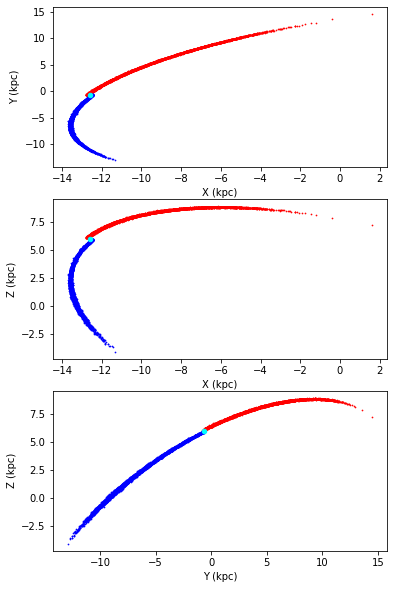

In [12]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6,10))
plt.subplot(3,1,1)
plt.scatter(-1.*xy_sample_trailing[0]*8.,xy_sample_trailing[1]*8.,s=0.5,c='r')
plt.scatter(-1*xy_sample_leading[0]*8.,xy_sample_leading[1]*8.,s=0.5,c='b')
plt.scatter(gc1.x.value,gc1.y.value,s=20,c='cyan')
#plt.vlines(gc1.x.value+0.2,-7.5,5.)
#plt.vlines(gc1.x.value-0.2,-7.5,5.)           
#plt.hlines(gc1.y.value+0.2,-13,-10)
#plt.hlines(gc1.y.value-0.2,-13,-10)
#plt.scatter(-o.x(),o.y(),s=20,c='pink')
plt.xlabel("X (kpc)")
plt.ylabel("Y (kpc)")

plt.subplot(3,1,2)
plt.scatter(-1.*xy_sample_trailing[0]*8.,xy_sample_trailing[2]*8.,s=0.5,c='r')
plt.scatter(-1*xy_sample_leading[0]*8.,xy_sample_leading[2]*8.,s=0.5,c='b')
plt.scatter(gc1.x.value,gc1.z.value,s=20,c='cyan')
#plt.scatter(-o.x(),o.z(),s=20,c='pink')
plt.xlabel("X (kpc)")
plt.ylabel("Z (kpc)")

plt.subplot(3,1,3)
plt.scatter(1.*xy_sample_trailing[1]*8.,xy_sample_trailing[2]*8.,s=0.5,c='r')
plt.scatter(1*xy_sample_leading[1]*8.,xy_sample_leading[2]*8.,s=0.5,c='b')
plt.scatter(gc1.y.value,gc1.z.value,s=20,c='cyan')
#plt.scatter(o.y(),o.z(),s=20,c='pink')
plt.xlabel("Y (kpc)")
plt.ylabel("Z (kpc)")
plt.show()

Align the stream such that the mean angular momentum of the particles around the progenitor points towards z axis
and construct the custom coordinates $(\phi_{1},\phi_{2})$. \
While doing so, print the rotation matrix which will be used to transform back forth from $(\phi_{1},\phi_{2})$


In [13]:
from galpy.util import _rotate_to_arbitrary_vector
#first combine leading and trailing arm points
#multiply x and vx by -1 since galpy uses left handed cartesian coordinates

x_all = np.concatenate((-1.*xy_sample_trailing[0]*8.,-1.*xy_sample_leading[0]*8.))
y_all = np.concatenate((xy_sample_trailing[1]*8.,xy_sample_leading[1]*8.))
z_all = np.concatenate((xy_sample_trailing[2]*8.,xy_sample_leading[2]*8.))
vx_all = np.concatenate((-1.*xy_sample_trailing[3]*220.,-1.*xy_sample_leading[3]*220.))
vy_all = np.concatenate((xy_sample_trailing[4]*220.,xy_sample_leading[4]*220.))
vz_all = np.concatenate((xy_sample_trailing[5]*220.,xy_sample_leading[5]*220.))

#the above are in galactocentric coordinates, transform them to Galactic coordinates
gc2=coord.Galactocentric(x=x_all*u.kpc,y=y_all*u.kpc,z=z_all*u.kpc,v_x=vx_all*(u.km/u.s),\
                         v_y=vy_all*(u.km/u.s),v_z=vz_all*(u.km/u.s),galcen_distance=8.*u.kpc,
                                galcen_v_sun=v_sun,
                                z_sun=25.*u.pc)

gal_c2=gc2.transform_to(coord.ICRS)
gal_c2.representation_type = 'cartesian'
    
_x = gal_c2.x.value ; _y = gal_c2.y.value ; _z = gal_c2.z.value ;
_vx = gal_c2.v_x.value ; _vy = gal_c2.v_y.value ; _vz = gal_c2.v_z.value;

#also change the progenitor's coordinates representation to cartesian (it's already in Galactic)
c1.representation_type = 'cartesian'
xc = c1.x.value; yc=c1.y.value; zc=c1.z.value; 

rcore = 0.2
#select particles within some r around the center
_r = np.sqrt((_x-xc)**2 + (_y-yc)**2 + (_z-zc)**2)

_x = _x[_r < rcore] ; _y = _y[_r < rcore] ; _z = _z[_r < rcore] ; 
_vx = _vx[_r < rcore]; _vy = _vy[_r < rcore] ; _vz = _vz[_r < rcore];

#compute mean angluar momentum of the selected particles
L = []

for ii in range(len(_x)):
    r = [_x[ii],_y[ii],_z[ii]]
    v = [_vx[ii],_vy[ii],_vz[ii]]
    #print (r,v)
    L.append(np.cross(r,v))

L = np.array(L)

mean_L = np.mean(L,axis=0)

#normalize
mean_l = np.mean(L,axis=0)/np.linalg.norm(np.mean(L,axis=0))
#print (mean_l)

#setup rotation matrix
rot_mat = _rotate_to_arbitrary_vector(np.atleast_2d(mean_l),np.array([0,0,1]),inv=False,_dontcutsmall=False)
print ("rotation matrix :")
print (rot_mat)

#Now rotate positions and velocities by the rotation matrix
print ("Check:",np.dot(rot_mat,mean_l))
r_rot = []
v_rot = []

for ii in range(len(x_all)):
    r = [gal_c2.x.value[ii],gal_c2.y.value[ii],gal_c2.z.value[ii]]
    v = [gal_c2.v_x.value[ii],gal_c2.v_y.value[ii],gal_c2.v_z.value[ii]]
    r_rot.append(np.dot(rot_mat,r)[0])
    v_rot.append(np.dot(rot_mat,v)[0])

r_rot = np.array(r_rot)
v_rot = np.array(v_rot)

xR = r_rot[:,0]; yR = r_rot[:,1]; zR = r_rot[:,2];
vxR = v_rot[:,0]; vyR = v_rot[:,1]; vzR = v_rot[:,2];


rotation matrix :
[[[ 0.3276296  -0.66212655  0.6739787 ]
  [-0.66212655  0.34796124  0.66371034]
  [-0.6739787  -0.66371034 -0.32440916]]]
Check: [[-5.55111512e-17  0.00000000e+00  1.00000000e+00]]


rotation matrix :
[[[ 0.32747477 -0.66189786  0.6742785 ]
  [-0.66189786  0.34856157  0.66362343]
  [-0.6742785  -0.66362343 -0.32396366]]]

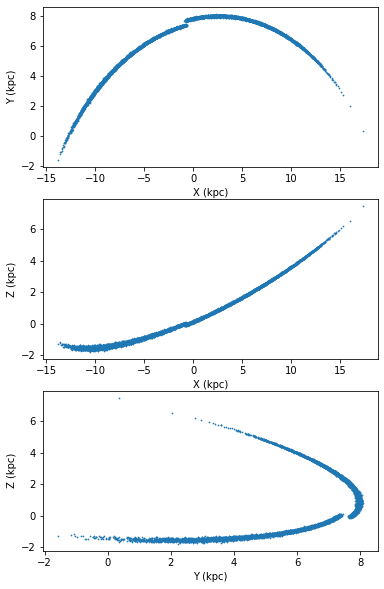

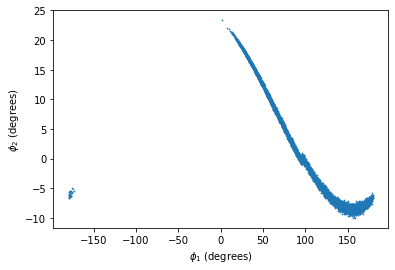

In [14]:
plt.figure(figsize=(6,10))
plt.subplot(3,1,1)
plt.scatter(xR,yR,s=0.5)
plt.xlabel("X (kpc)")
plt.ylabel("Y (kpc)")

plt.subplot(3,1,2)
plt.scatter(xR,zR,s=0.5)
plt.xlabel("X (kpc)")
plt.ylabel("Z (kpc)")

plt.subplot(3,1,3)
plt.scatter(yR,zR,s=0.5)
plt.xlabel("Y (kpc)")
plt.ylabel("Z (kpc)")
plt.show()

#convert to angle coordinates
phi1 = np.degrees(np.arctan2(yR,xR))
phi2 = np.degrees(np.arctan2(zR,np.sqrt(xR**2 + yR**2)))

plt.figure()
plt.scatter(phi1,phi2,s=0.5)
plt.xlabel(r"$\phi_{1}$ (degrees)")
plt.ylabel(r"$\phi_{2}$ (degrees)")
plt.show()

Check dens(angle)

In [15]:
apar_out=np.arange(0.01,1.1,0.01)
#sdf_smooth=gd1_util.setup_gd1model(leading=options.leading_arm,age=tstream,new_orb_lb=new_orb_lb,isob=isob,sigv=sigv)
dens_unp= [sdf_trailing._density_par(a) for a in apar_out]
omega_unp= [sdf_trailing.meanOmega(a,oned=True) for a in apar_out]

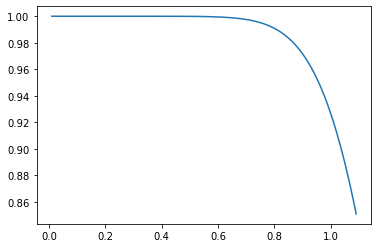

In [16]:
plt.figure()
plt.plot(apar_out,dens_unp,label='fid')
plt.show()

Combine 

In [17]:
def lb_to_customGD1phi12(l,b,degree=True):
    
    #first covert to ra,dec 
    radec = coords.lb_to_radec(l,b,degree=degree,epoch=2000.0)      
    
    if degree :
        ra= np.radians(radec[:,0])
        dec= np.radians(radec[:,1])
        
    else:
        ra= radec[:,0]
        dec= radec[:,1]
        
    XYZ= np.array([np.cos(dec)*np.cos(ra),
                      np.cos(dec)*np.sin(ra),
                      np.sin(dec)])

    _TKOP= np.zeros((3,3))
    _TKOP[0,:]= [ 0.32747477, -0.66189786, 0.6742785 ]  
    _TKOP[1,:]= [-0.66189786, 0.34856157, 0.66362343]
    _TKOP[2,:]= [-0.6742785, -0.66362343, -0.32396366]

    phiXYZ= np.dot(_TKOP,XYZ)
    
    phi2= np.arctan2(phiXYZ[2],np.sqrt(phiXYZ[1]**2+phiXYZ[0]**2))
    phi1= np.arctan2(phiXYZ[1],phiXYZ[0])
    
    if degree :
        return (np.degrees(phi1),np.degrees(phi2))
    else:
        return (phi1,phi2)

def compute_dens_contrast(sdf_object,apars,dens,dens_smooth,mO,poly_deg=3,cut_around_progenitor=20.):
    """
    PURPOSE:
        Convert dens (angle coordinates) to dens_contrast(observed coordinates)
    INPUT:
        apars - parallel angles
        dens - density(apars)
        dens_smooth - smooth-stream density(apars)
        mO= (None) mean parallel frequency (1D) 
            [needs to be set to get density on same grid as track]
        poly_deg= (3) degree of the polynomial to fit for the 'smooth' stream
    OUTPUT:
        (phi1,dens/smooth)
    """
    with open(sdf_object,'rb') as savefile:
        sdf_smooth= pickle.load(savefile,encoding='latin1')
        sdf_pepper= pickle.load(savefile,encoding='latin1')
        
    mT= sdf_pepper.meanTrack(apars,_mO=mO,coord='lb')
        
    phi1,phi2=lb_to_customGD1phi12(mT[0],mT[1],degree=True)
    
    o= Orbit.from_name("GD1")
    p1_prog,p2_prog = lb_to_customGD1phi12(np.array([o.ll()]),np.array([o.bb()]),degree=True)
    #print (phi1)
    if phi1[1] < phi1[0]:
        
        ipphi1= interpolate.InterpolatedUnivariateSpline(phi1[::-1],apars[::-1])
        outphi1= np.linspace(40.,p1_prog - cut_around_progenitor,300)
        
    else :
        ipphi1= interpolate.InterpolatedUnivariateSpline(phi1,apars)
        outphi1= np.linspace(p1_prog + cut_around_progenitor,160. ,300)
        
    # Interpolate density contrast
    ipdens= interpolate.InterpolatedUnivariateSpline(apars,dens/dens_smooth)
    return (outphi1,ipdens(ipphi1(outphi1)))


collect all the sims and convert to physical coordinates and write them in one file

In [20]:
arm = "leading"
cut_around_progenitor = 20.

o= Orbit.from_name("GD1")
p1_prog,p2_prog = lb_to_customGD1phi12(np.array([o.ll()]),np.array([o.bb()]),degree=True)

if arm =="trailing":
    outphi1= np.linspace(40.,p1_prog - cut_around_progenitor,300)
        
else :
    outphi1= np.linspace(p1_prog + cut_around_progenitor,160. ,300)
    
sdf_object='mockgd1_pepper_{}_Plummer_sigv0.46_td4.0_86sampling_InterpSphPotAnalyticDisk.pkl'.format(arm)

file_name = "dens_Omega/" + 'dens_contrast_'+arm+'_mockgd1stream_physical_coordinates.dat'.format(arm)

import os
if not os.path.exists(file_name):
    fo = open(file_name,'w',newline='')
    fowriter= csv.writer(fo,delimiter=',')

    fowriter.writerow([pp[0] for pp in outphi1])

    allfname= glob.glob("dens_Omega/"+arm+'/'+ '*.dat')
    for fname in allfname :
        try:
            apars,dens_unp,dens,omega_unp,omega = np.loadtxt(fname,unpack=True)
            phi1,denss = compute_dens_contrast(sdf_object,apars,dens,dens_unp,omega,poly_deg=3)

            fowriter.writerow([pp[0] for pp in denss])

        except ValueError as e:
            print (fname)
            #pass

    fo.flush()
    fo.close() 
    
    

In [21]:
#power spectrum from dens already converted to observed coordinates
def compute_pk_scatter(fname,N,scatter=False,scaling='spectrum'):
    
    data=np.loadtxt(fname,delimiter=',')
    p1 = data[0]
    dens = data[1]
    px,py= signal.csd(dens,dens,fs=1./(p1[1]-p1[0]),scaling='spectrum',nperseg=len(p1))
    py= py.real
       
    ppy= np.empty((N,len(px)))
         
    for ii in range(1,N):
        py= signal.csd(data[ii],data[ii],fs=1./(p1[1]-p1[0]),scaling='spectrum',nperseg=len(p1))[1].real
        ppy[ii]=py
    
    if not scatter:
        return (1./px,np.sqrt(np.nanmedian(ppy,axis=0)*(p1[-1]-p1[0])))
        
    else:
        out= np.sqrt(np.nanmedian(ppy,axis=0)*np.abs(p1[-1]-p1[0]))
                
        ppy.sort(axis=0)
        
        return (1./px,out,
                np.sqrt(ppy[int(np.round(0.023*N))]*(p1[-1]-p1[0])),
                np.sqrt(ppy[int(np.round(0.977*N)-1)]*(p1[-1]-p1[0])))
                #np.sqrt(ppy[int(np.round(0.159*N))]*(ll[-1]-ll[0])),
                #np.sqrt(ppy[int(np.round(0.84*N)-2)]*(ll[-1]-ll[0])))
                

/scratch/user/banik/.conda/envs/galpy1.7/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in true_divide

/scratch/user/banik/.conda/envs/galpy1.7/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in true_divide



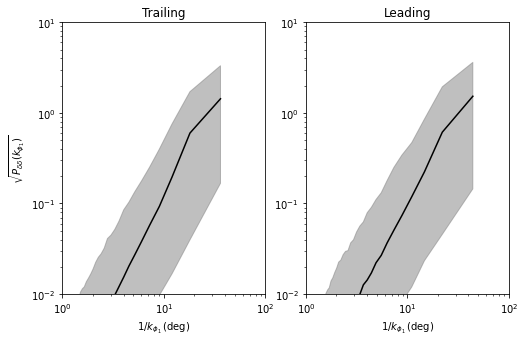

In [22]:
N=1000
fn_trail = "dens_Omega/dens_contrast_trailing_mockgd1stream_physical_coordinates.dat"  
fn_lead = "dens_Omega/dens_contrast_leading_mockgd1stream_physical_coordinates.dat" 

px_trail, py_trail= compute_pk_scatter(fname=fn_trail,N=N,scatter=False)
plotx_t, dum, low_t, high_t= compute_pk_scatter(fn_trail,N=N,scatter=True) 

px_lead, py_lead= compute_pk_scatter(fname=fn_lead,N=N,scatter=False)
plotx_l, dum, low_l, high_l= compute_pk_scatter(fn_lead,N=N,scatter=True) 

plt.figure(figsize=(8,5))

ax1=plt.subplot(1,2,1)
ax1.set_title("Trailing")
plt.loglog(px_trail, py_trail,color='k')
plt.fill_between(plotx_t,low_t,high_t,color='gray',alpha=0.5)
#loglog(px0,pyerr0,color='g',ls='--',zorder=1)
plt.ylabel(r'$\sqrt{P_{\delta\delta}(k_{\phi_{1}})}$',size=10)
plt.xlabel(r'$1/k_{\phi_{1}}\,(\mathrm{deg})$',size=10)
plt.ylim(0.01,10.)
plt.xlim(1,100.)


ax2=plt.subplot(1,2,2)
ax2.set_title("Leading")
plt.loglog(px_lead, py_lead,color='k')
plt.fill_between(plotx_l,low_l,high_l,color='gray',alpha=0.5)
plt.xlabel(r'$1/k_{\phi_{1}}\,(\mathrm{deg})$',size=10)
plt.ylim(0.01,10.)
plt.xlim(1,100.)

#plt.legend(loc='lower right')
plt.show()

In [ ]:
plt.figure()
plt.loglog(px,py,lw=2.,color=color,zorder=zorder,ls=ls,label=label)
plotx, dum, low, high= compute_pk_scatter(fname,N=N,scatter=True)  
plt.fill_between(plotx,low,high,color=fill_color,zorder=fill_zorder,alpha=0.5)
        #errorbar(plotx,py,yerr=[py-low,py+high],color=color,fmt='o',capsize=5.,capthick=1.,ecolor=color)
        #set_yscale('log')
        #set_xscale('log')
    plt.legend(loc='upper left',fontsize=12)   
    plt.xlabel(r'$1/k_{\phi_{1}}\,(\mathrm{deg})$',size=10)
    plt.ylim(0.01,10.)
    plt.xlim(1,100.)
    plt.show()
    return None

In [ ]:
arm = "leading"
fn = "dens_Omega/" + 'dens_contrast_'+arm+'_mockgd1stream_physical_coordinates.dat'.format(arm)
plot_pk_scatter(fn,100)

In [ ]:
def Hern_mass(r,Mtot,a):
    return (Mtot*(r/(r+a))**2)

print ("%.2e"%Hern_mass(108.,1.03e12,40.82))

In [ ]:
data = np.loadtxt("dens_Omega/" + 'dens_contrast_'+arm+'_mockgd1stream_physical_coordinates.dat'.format(arm),delimiter=',')

plt.figure()
plt.plot(data[0],data[1])
plt.show()

In [ ]:
arm='trailing'
sdf_object='mockgd1_pepper_{}_Plummer_sigv0.46_td4.0_86sampling_InterpSphPotAnalyticDisk.pkl'.format(arm)

apars,dens_unp,dens,omega_unp,omega = \
np.loadtxt("dens_Omega/{}/mockGD1_sigv0.46_{}_densOmega_CDMsubhalo_Hernquist_718051.dat".format(arm,arm),unpack=True)

phi1,denss = compute_dens_contrast(sdf_object,apars,dens,dens_unp,omega,poly_deg=3)

plt.figure()
plt.plot(phi1,denss)
plt.show()



